# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### Import Packages

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shapiq

print(f"shapiq version: {shapiq.__version__}")

shapiq version: 1.3.1


### Load Data
Let's load the California housing dataset and split it into training and test sets.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.25,
    random_state=42,
)
n_features = X_train.shape[1]

### Train a Model with Scikit-learn
Here we train a random forest regressor with 500 trees.
The model achieves a relatively high R2 score on the test set.

In [3]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=n_features,
    max_features=2 / 3,
    max_samples=2 / 3,
    random_state=42,
)
model.fit(X_train, y_train)
print(f"Train R2: {model.score(X_train, y_train):.4f}")
print(f"Test  R2: {model.score(X_test, y_test):.4f}")

Train R2: 0.7990
Test  R2: 0.7462


### Model-Agnostic Explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:

- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.

- `data`: A background dataset to be used for imputation.

In [4]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII", max_order=2)

Next, select an instance to be explained.

In [5]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [6]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0699756848160713
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
interaction_values.dict_values

{(): 0.0,
 (0,): 0.020484624719212776,
 (1,): -0.0785128929647524,
 (2,): -0.02162128598707656,
 (3,): 0.015128949771652269,
 (4,): 0.0200076956418658,
 (5,): -0.15178267833288583,
 (6,): 0.15240850658096355,
 (7,): -0.26370541887943244,
 (0, 1): -0.04764218680740207,
 (0, 2): 0.012576943602299698,
 (0, 3): -0.02261729432262708,
 (0, 4): -0.020549776380014255,
 (0, 5): -0.08577577456559268,
 (0, 6): -0.05613251348157957,
 (0, 7): 0.013367607234074916,
 (1, 2): -0.015903570255961865,
 (1, 3): -0.019158614399118996,
 (1, 4): -0.019440193548710828,
 (1, 5): 0.10827181769785353,
 (1, 6): -0.022544661282841313,
 (1, 7): -0.02214269466376014,
 (2, 3): -0.020717978807992084,
 (2, 4): -0.020195590754244933,
 (2, 5): -0.022112473399827064,
 (2, 6): -0.01580839632273254,
 (2, 7): -0.027496236554089965,
 (3, 4): -0.020482125886339273,
 (3, 5): -0.01621707535166403,
 (3, 6): -0.02241574466852325,
 (3, 7): -0.020535040026035678,
 (4, 5): -0.02450333451399985,
 (4, 6): -0.02123922504682013,
 (4, 7):

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [8]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.04764218680740207,
 (0, 2): 0.012576943602299698,
 (0, 3): -0.02261729432262708,
 (0, 4): -0.020549776380014255,
 (0, 5): -0.08577577456559268,
 (0, 6): -0.05613251348157957,
 (0, 7): 0.013367607234074916,
 (1, 2): -0.015903570255961865,
 (1, 3): -0.019158614399118996,
 (1, 4): -0.019440193548710828,
 (1, 5): 0.10827181769785353,
 (1, 6): -0.022544661282841313,
 (1, 7): -0.02214269466376014,
 (2, 3): -0.020717978807992084,
 (2, 4): -0.020195590754244933,
 (2, 5): -0.022112473399827064,
 (2, 6): -0.01580839632273254,
 (2, 7): -0.027496236554089965,
 (3, 4): -0.020482125886339273,
 (3, 5): -0.01621707535166403,
 (3, 6): -0.02241574466852325,
 (3, 7): -0.020535040026035678,
 (4, 5): -0.02450333451399985,
 (4, 6): -0.02123922504682013,
 (4, 7): -0.019761805713043118,
 (5, 6): -0.034624333228500066,
 (5, 7): 0.000445965118375562,
 (6, 7): -0.04462659303006044}

In [9]:
interaction_values.get_n_order_values(2)

array([[ 0.        , -0.04764219,  0.01257694, -0.02261729, -0.02054978,
        -0.08577577, -0.05613251,  0.01336761],
       [-0.04764219,  0.        , -0.01590357, -0.01915861, -0.01944019,
         0.10827182, -0.02254466, -0.02214269],
       [ 0.01257694, -0.01590357,  0.        , -0.02071798, -0.02019559,
        -0.02211247, -0.0158084 , -0.02749624],
       [-0.02261729, -0.01915861, -0.02071798,  0.        , -0.02048213,
        -0.01621708, -0.02241574, -0.02053504],
       [-0.02054978, -0.01944019, -0.02019559, -0.02048213,  0.        ,
        -0.02450333, -0.02123923, -0.01976181],
       [-0.08577577,  0.10827182, -0.02211247, -0.01621708, -0.02450333,
         0.        , -0.03462433,  0.00044597],
       [-0.05613251, -0.02254466, -0.0158084 , -0.02241574, -0.02123923,
        -0.03462433,  0.        , -0.04462659],
       [ 0.01336761, -0.02214269, -0.02749624, -0.02053504, -0.01976181,
         0.00044597, -0.04462659,  0.        ]])

### Visualization of Shapley interactions

`shapiq` includes the following plotting functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 700x700 with 1 Axes>, <Axes: >)

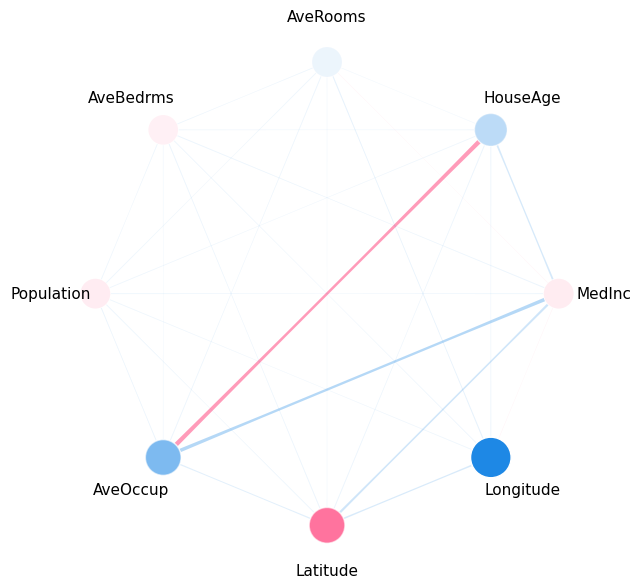

In [10]:
shapiq.network_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

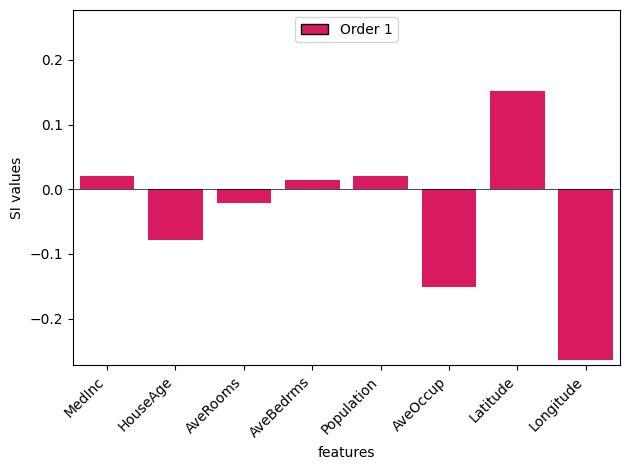

In [11]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

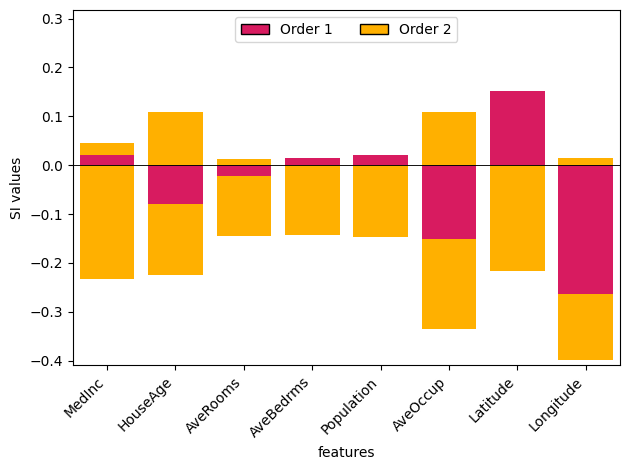

In [12]:
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

After installing the `shap` Python package.

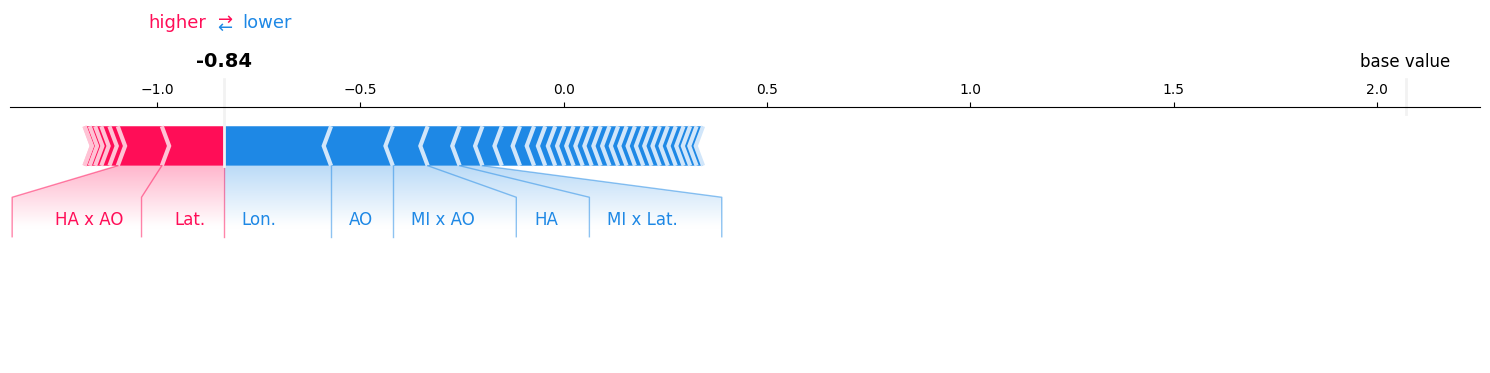

In [13]:
interaction_values.plot_force(feature_names=X.columns)